# Time Series Analysis

### Ayush Yadav (MDS202315)
### Kalyani Gohokar (MDS202330)

In [500]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import pmdarima as pm

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse 

from tqdm import tqdm

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Image

### Data

In [413]:
data = pd.read_csv('./data/uk_data_2009_2024_raw.csv')[['settlement_date','nd','tsd','england_wales_demand']]
print(data.shape)
data.head()

(277246, 4)


,settlement_date,nd,tsd,england_wales_demand
0,2009-01-01,37910,38704,33939
1,2009-01-01,38047,38964,34072
2,2009-01-01,37380,38651,33615
3,2009-01-01,36426,37775,32526
4,2009-01-01,35687,37298,31877


In [414]:
data_new = data[['settlement_date', 'nd']]
data_new = data_new.rename(columns = {'settlement_date':'date', 'nd':'demand'})
data_new.date = data_new['date'].apply(lambda x: str(x).split()[0])
data_new_daily = data_new.groupby('date').sum()
data_new_daily.index = pd.to_datetime(data_new_daily.index)

data_new_daily = data_new_daily.resample('W').sum()
data_new_daily['log_demand'] = np.log(data_new_daily.demand.values)
data_new_daily = data_new_daily.drop(labels = ['2009-01-04','2024-10-27'], axis=0)
data_new_daily

,demand,log_demand
date,,
2009-01-11,15046759,16.526673
2009-01-18,14080079,16.460272
2009-01-25,14237170,16.471367
2009-02-01,14246472,16.472020
2009-02-08,14846340,16.513264
...,...,...
2024-09-22,8012108,15.896464
2024-09-29,8579032,15.964832
2024-10-06,8733035,15.982624


In [415]:
data_new_daily.describe()

,demand,log_demand
count,8.240000e+02,824.000000
mean,1.048026e+07,16.150856
std,1.757992e+06,0.168978
min,6.949133e+06,15.754127
25%,9.089515e+06,16.022632
50%,1.049586e+07,16.166491
75%,1.158997e+07,16.265651
max,1.524844e+07,16.539988


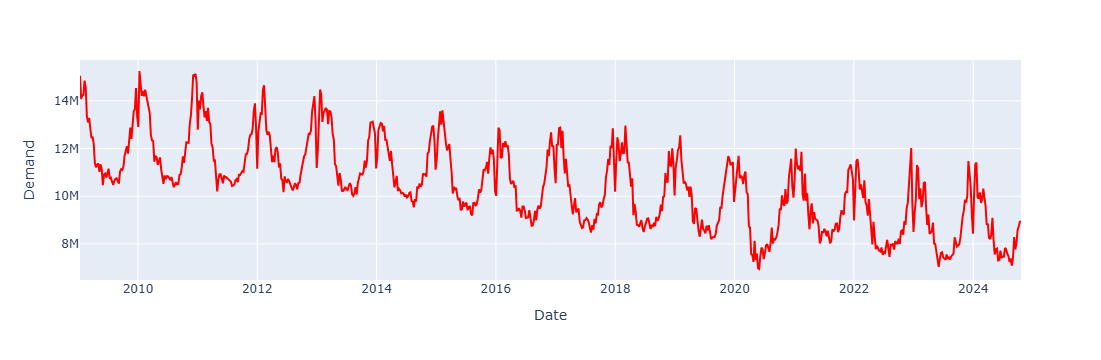

In [416]:
fig_overview = px.line(data_new_daily, x=data_new_daily.index, y='demand')
fig_overview.update_xaxes(title_text='Date')
fig_overview.update_yaxes(title_text='Demand')
fig_overview.update_traces(line=dict(color='red'))
fig_overview.show()

### Log Transformed Data

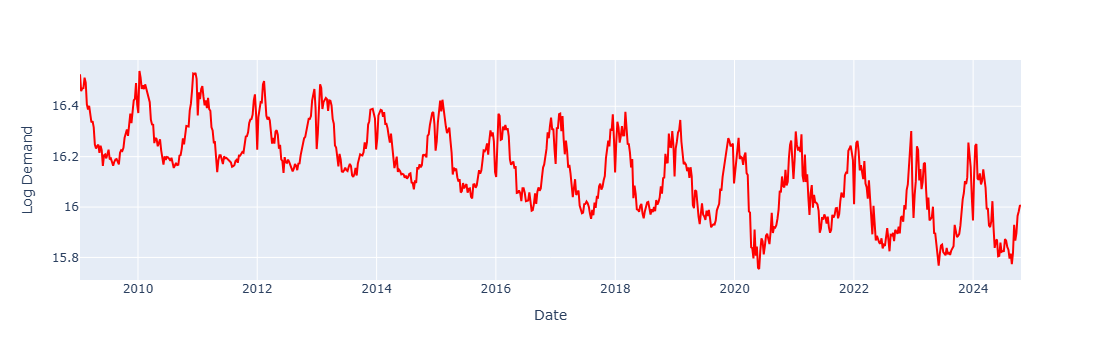

In [417]:
fig_overview = px.line(data_new_daily, x=data_new_daily.index, y='log_demand')
fig_overview.update_xaxes(title_text='Date')
fig_overview.update_yaxes(title_text='Log Demand')
fig_overview.update_traces(line=dict(color='red'))
fig_overview.show()

In [418]:
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

data_new_daily['month'] = data_new_daily.index.month
data_new_daily['year'] = data_new_daily.index.year

data_new_daily

,demand,log_demand,month,year
date,,,,
2009-01-11,15046759,16.526673,1,2009
2009-01-18,14080079,16.460272,1,2009
2009-01-25,14237170,16.471367,1,2009
2009-02-01,14246472,16.472020,2,2009
2009-02-08,14846340,16.513264,2,2009
...,...,...,...,...
2024-09-22,8012108,15.896464,9,2024
2024-09-29,8579032,15.964832,9,2024
2024-10-06,8733035,15.982624,10,2024


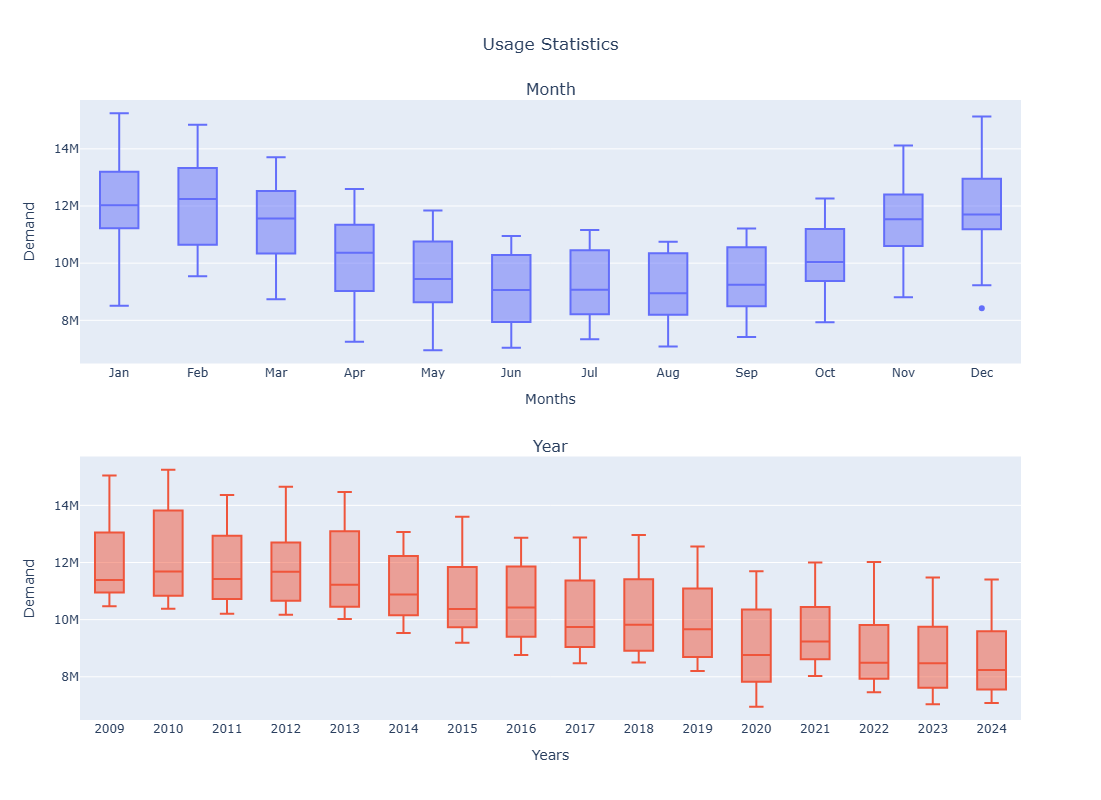

In [419]:
fig_subplot = make_subplots(rows=2, cols=1, shared_yaxes=True,  subplot_titles=['Month','Year'], vertical_spacing=0.15)

fig_subplot.append_trace(go.Box(x=data_new_daily['month'], y=data_new_daily['demand']), row=1, col=1)
fig_subplot.append_trace(go.Box(x=data_new_daily['year'], y=data_new_daily['demand']), row=2, col=1)

fig_subplot.update_xaxes(
    title_text='Months',
    tickvals=list(months.keys()), 
    ticktext=list(months.values()), 
    row=1, col=1
)

fig_subplot.update_xaxes(
    title_text='Years',
    tickvals=list(range(2009,2025)), 
    row=2, col=1
)

fig_subplot.update_yaxes(title_text='Demand')

fig_subplot.update_layout(height=800, width=1350, showlegend=False, title='Usage Statistics', title_x=0.5)
fig_subplot.show()

### Moving Average Smoothing

In [ ]:
df = data_new_daily[['demand']].copy()

df['log_demand'] = np.log(df['demand']) 
df['monthly_ma'] = df['log_demand'].rolling(window=4).mean()
df['quarterly_ma'] = df['log_demand'].rolling(window=12).mean()
df['monthly_std'] = df['log_demand'].rolling(window=4).std()

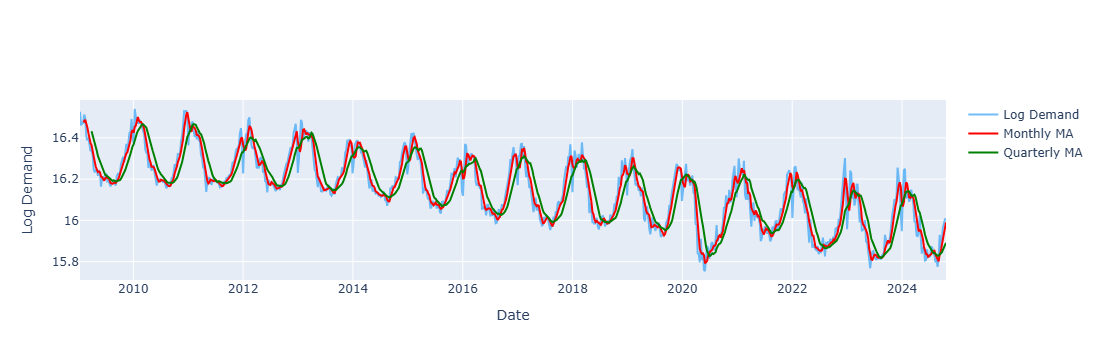

In [421]:
fig_ma = make_subplots(rows=1, cols=1)

fig_ma.add_trace(go.Scatter(x=df.index, y=df.log_demand, mode='lines', name='Log Demand', line=dict(color='#42a7f5') ,opacity=0.75))

fig_ma.add_trace(go.Scatter(x=df.index, y=df.monthly_ma, mode='lines', name='Monthly MA',line=dict(color='red')))
fig_ma.add_trace(go.Scatter(x=df.index, y=df.quarterly_ma, mode='lines', name='Quarterly MA',line=dict(color='green')))
# fig_ma.add_trace(go.Scatter(x=df.index, y=df.monthly_std, mode='lines', name='Variance', line=dict(color='black')))

fig_ma.update_xaxes(title_text='Date')
fig_ma.update_yaxes(title_text='Log Demand')
fig_ma.update_layout(showlegend=True)

fig_ma.show()

### Seasonal Decomposition

In [422]:
data = data_new_daily[['demand']].copy()
data['log_demand'] = np.log(data['demand'].values)
data

,demand,log_demand
date,,
2009-01-11,15046759,16.526673
2009-01-18,14080079,16.460272
2009-01-25,14237170,16.471367
2009-02-01,14246472,16.472020
2009-02-08,14846340,16.513264
...,...,...
2024-09-22,8012108,15.896464
2024-09-29,8579032,15.964832
2024-10-06,8733035,15.982624


In [466]:
res_mul = seasonal_decompose(x=data[['log_demand']], model='multiplicative', period=52)
mul_trend = res_mul.trend
mul_seasonal = res_mul.seasonal
mul_resids = res_mul.resid


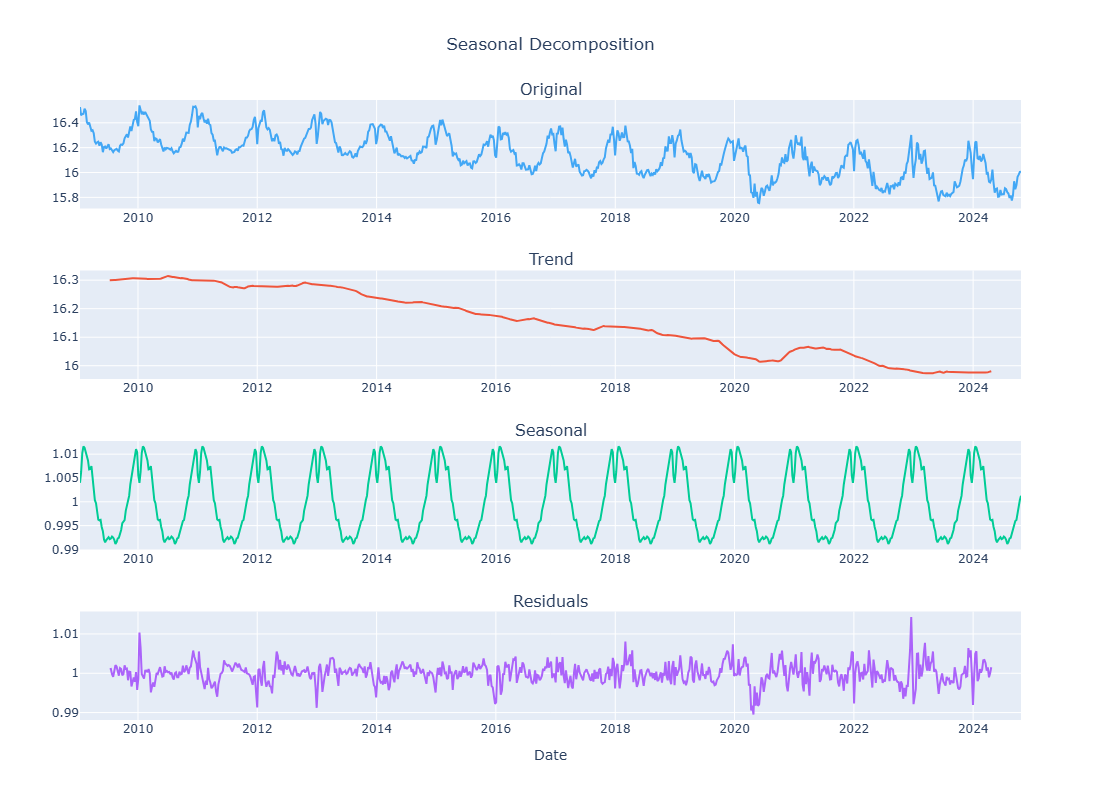

In [467]:
fig_decomp_mul = make_subplots(rows=4, cols=1, shared_yaxes=True,  subplot_titles=['Original','Trend','Seasonal','Residuals'], vertical_spacing=0.1)

fig_decomp_mul.append_trace(go.Scatter(x=data.index, y=data.log_demand, mode='lines',line=dict(color='#42a7f5')), row=1, col=1)
fig_decomp_mul.append_trace(go.Scatter(x=data.index, y=mul_trend, mode='lines'), row=2, col=1)
fig_decomp_mul.append_trace(go.Scatter(x=data.index, y=mul_seasonal, mode='lines'), row=3, col=1)
fig_decomp_mul.append_trace(go.Scatter(x=data.index, y=mul_resids, mode='lines'), row=4, col=1)

fig_decomp_mul.update_xaxes(
    title_text='Date',
    row=4, col=1
)

fig_decomp_mul.update_layout(height=800, width=1350, showlegend=False, title_text='Seasonal Decomposition', title_x=0.5)
fig_decomp_mul.show()

### Test for Stationarity

#### Before Differencing

In [426]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Series is Stationary")
    else:
        print("Series is Non-Stationary")

def kpss_test(series):
    result = kpss(series)
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Series is Non-Stationary")
    else:
        print("Series is Stationary")

In [468]:
adf_test(data[['log_demand']])

ADF Statistic: -4.1299068145032996
p-value: 0.0008639670160925548
Series is Stationary


In [469]:
kpss_test(data[['log_demand']])

KPSS Statistic: 2.9243058206077954
p-value: 0.01
Series is Non-Stationary


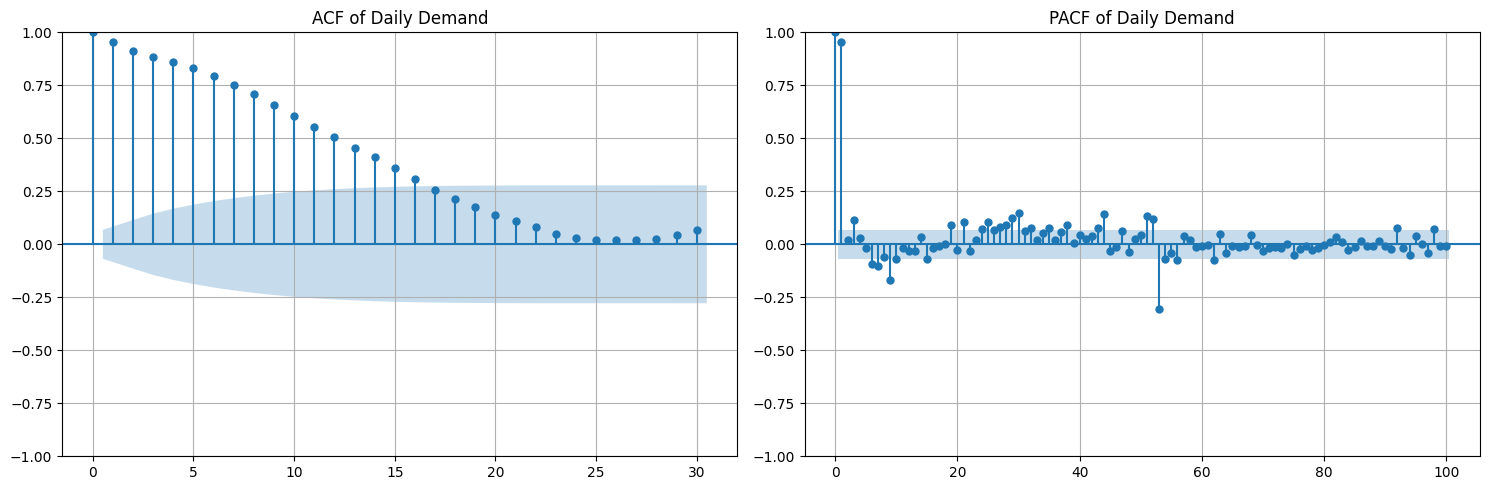

In [429]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(df[['log_demand']], ax=axs[0], title='ACF of Daily Demand')
axs[0].grid(True)

plot_pacf(df[['log_demand']], ax=axs[1], title='PACF of Daily Demand', lags=100)
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### After Differencing

In [430]:
data['difference_1'] = data['log_demand'].diff(52)

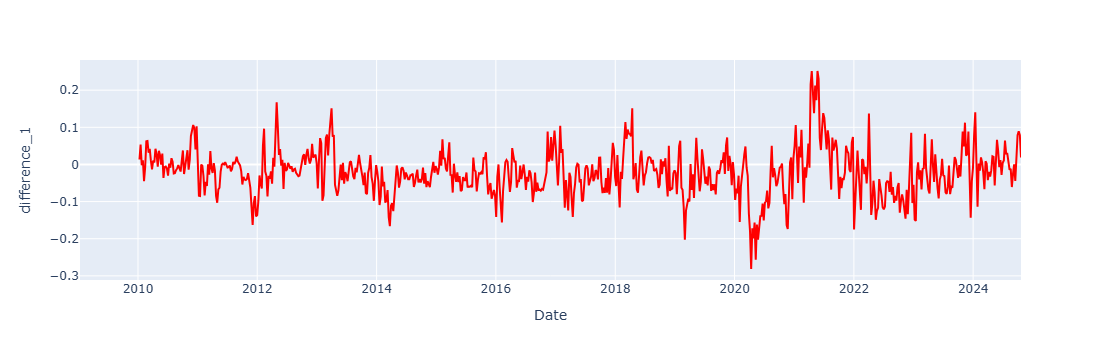

In [431]:
fig_overview = px.line(data, x=data.index, y='difference_1')
fig_overview.update_xaxes(title_text='Date')
fig_overview.update_traces(line=dict(color='red'))
fig_overview.show()

In [432]:
kpss_test(data['difference_1'].dropna())

KPSS Statistic: 0.11230510944431465
p-value: 0.1
Series is Stationary


In [470]:
adf_test(data['difference_1'].dropna())

ADF Statistic: -6.291061810831453
p-value: 3.598374044882775e-08
Series is Stationary


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(data['difference_1'].dropna(), ax=axs[0], title='ACF after Differencing', lags = 50)
axs[0].grid(True)

plot_pacf(data['difference_1'].dropna(), ax=axs[1], title='PACF after Differencing', lags = 50)
axs[1].grid(True)

plt.tight_layout()
plt.show()

![7. acf_pacf_diff.png](<attachment:7. acf_pacf_diff.png>)
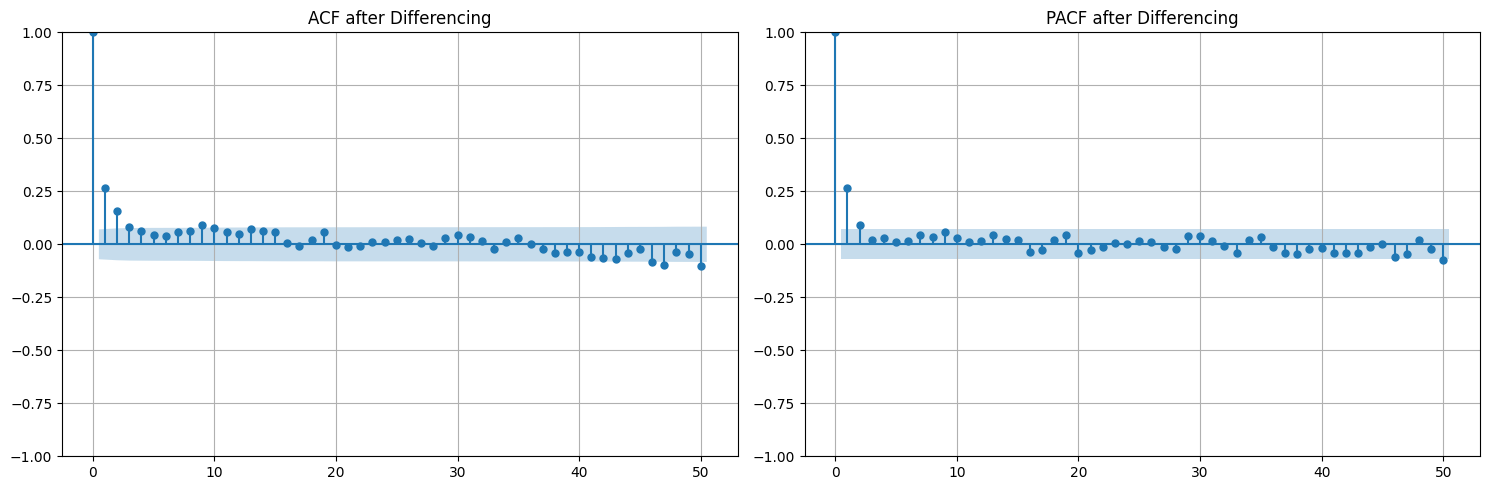

### Train Test Split

In [488]:
train_data = data[data.index < '2022-01-01']
test_data = data[data.index >= '2022-01-01']

### SARIMA Model

In [ ]:
ps, qs, Ps, Qs, ds = [1,2], [1,2], [1,2], [1,2], [0,1]

models = []
AICs = []

for d in ds:
    for p in ps:
        for q in qs:
            for P in Ps:
                for Q in Qs:

                    model = pm.ARIMA(
                        order=(p, d, q),
                        seasonal_order=(P, 1, Q, 52),
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True
                    ) 

                    fitted_model = model.fit(train_data['log_demand'])

                    models.append(fitted_model)
                    AICs.append(fitted_model.aic())

Done!


In [ ]:
MAEs, MSEs = [], []
for mdl in models:
    forecast = mdl.predict(n_periods=n_steps)
    MAEs.append(mae(test_data['log_demand'],forecast))
    MSEs.append(mse(test_data['log_demand'],forecast))

In [ ]:
RESULTS = pd.DataFrame(columns=['Model','AIC','MAE','MSE'])

RESULTS['AIC'] = AICs
RESULTS['MAE'] = MAEs
RESULTS['MSE'] = MSEs

RESULTS.to_csv('./results/results_sarima.csv', index=None)

In [360]:
sarima_res = pd.read_csv("./results/results_sarima.csv")
sarima_res.sort_values(by='AIC').head()

,Model,AIC,MAE,MSE
4,"ARIMA(1,0,2)(1,1,1)[52]",-2320.714917,0.042514,0.003290
12,"ARIMA(2,0,2)(1,1,1)[52]",-2320.573188,0.042647,0.003285
7,"ARIMA(1,0,2)(2,1,2)[52]",-2319.139976,0.042391,0.003245
6,"ARIMA(1,0,2)(2,1,1)[52]",-2318.993296,0.042366,0.003240
14,"ARIMA(2,0,2)(2,1,1)[52]",-2318.956193,0.042305,0.003230


In [ ]:
model_best_aic = pm.ARIMA(
                order=(1, 0, 2),
                seasonal_order=(1, 1, 1, 52),
                trace=True,
                error_action='ignore',
                suppress_warnings=True
            ) 

fitted_model_aic = model_best_aic.fit(train_data['log_demand'])

model_best_mse = pm.ARIMA(
                order=(2, 0, 2),
                seasonal_order=(2, 1, 1, 52),
                trace=True,
                error_action='ignore',
                suppress_warnings=True
            ) 

fitted_model_mse = model_best_mse.fit(train_data['log_demand'])

In [458]:
print(fitted_model_aic.aic())
print(fitted_model_mse.aic())

-2320.74744887374
-2318.681154026126


In [434]:
n_steps = len(test_data) 
forecast_aic = fitted_model_aic.predict(n_periods=n_steps)
forecast_mse = fitted_model_mse.predict(n_periods=n_steps)

forecast_aic_og = np.exp(forecast_aic.values)
forecast_mse_og = np.exp(forecast_mse.values)

forecast_index = pd.date_range(start=train_data.index[-1], periods=n_steps+1, freq='W')[1:]

fig_fc_sarima0 = make_subplots(rows=2, cols=1, subplot_titles = ['Best AIC Model - ARIMA(1,0,2)(1,1,1)[52]', 'Best MSE Model - ARIMA(2,0,2)(1,1,1)[52]'], vertical_spacing=0.1)

fig_fc_sarima0.add_trace(go.Scatter(x=train_data.index, y=train_data.demand, mode='lines', name='Training Data', line=dict(color='#42a7f5')))
fig_fc_sarima0.add_trace(go.Scatter(x=test_data.index, y=test_data.demand, mode='lines', name='Test Data',line=dict(color='red')))
fig_fc_sarima0.add_trace(go.Scatter(x=forecast_index, y=forecast_aic_og, mode='lines', name='SARIMA Forecast',line=dict(color='green')))

fig_fc_sarima0.append_trace(go.Scatter(x=train_data.index, y=train_data.demand, mode='lines', showlegend=False,  line=dict(color='#42a7f5')), row=2,col=1)
fig_fc_sarima0.add_trace(go.Scatter(x=test_data.index, y=test_data.demand, mode='lines',line=dict(color='red'),showlegend=False), row=2,col=1)
fig_fc_sarima0.add_trace(go.Scatter(x=forecast_index, y=forecast_mse_og, mode='lines',line=dict(color='green'), showlegend=False), row=2,col=1)

fig_fc_sarima0.update_xaxes(title_text='Date', row=2, col=1)
fig_fc_sarima0.update_yaxes(title_text='Demand')
fig_fc_sarima0.update_layout(height = 800,showlegend=True, title='SARIMA Forecasts', title_x=0.465)
fig_fc_sarima0.show()

### Holts Winters Model

In [497]:
hw_model_add = ExponentialSmoothing(
    train_data['log_demand'],            
    trend='add',                         
    seasonal='add',                      
    seasonal_periods=52                  
)

hw_model_mul = ExponentialSmoothing(
    train_data['log_demand'],            
    trend='mul',                         
    seasonal='mul',                      
    seasonal_periods=52                  
)

fitted_hw_model_add = hw_model_add.fit()
fitted_hw_model_mul = hw_model_add.fit()

In [498]:
n_steps = len(test_data)

hw_add_forecast_og = fitted_hw_model_add.forecast(n_steps)
hw_add_forecast_og = np.exp(hw_add_forecast_og)

fig_hw = make_subplots(rows=1, cols=1,)
fig_hw.add_trace(go.Scatter(x=train_data.index, y=train_data.demand, mode='lines', name='Training Data',line=dict(color='#42a7f5')))
fig_hw.add_trace(go.Scatter(x=test_data.index, y=test_data.demand, mode='lines', name='Test Data',line=dict(color='red')))
# fig_hw.add_trace(go.Scatter(x=test_data.index, y=hw_mul_forecast, mode='lines', name='HW Additive Forecast',line=dict(color='blue')))
fig_hw.add_trace(go.Scatter(x=test_data.index, y=hw_add_forecast_og, mode='lines', name='HW Forecast',line=dict(color='green')))
fig_hw.update_xaxes(title_text='Date')
fig_hw.update_yaxes(title_text='Demand')
fig_hw.update_layout(showlegend=True, title='Holt Winters Forecast', title_x=0.5)
fig_hw.show()

In [494]:
hw_mse = mse(test_data['log_demand'], hw_add_forecast)
hw_mae = mae(test_data['log_demand'], hw_add_forecast)
hw_aic = fitted_hw_model_mul.aic

print(f'''Holt Winters Model
----------------------------------
MAE = {hw_mae},
MSE = {hw_mse}
AIC = {hw_aic}
''')

Holt Winters Model
----------------------------------
MAE = 0.10137047332591437,
MSE = 0.013020251785401062
AIC = -4420.093938969786



### LSTM

In [475]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [476]:
df = data_new_daily[['log_demand']]

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

In [477]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

seq_length = 4
X, y = create_sequences(df_scaled, seq_length)

In [478]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [479]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [233]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTM_Model, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=100, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=100, hidden_size=80, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=80, hidden_size=60, batch_first=True)
        
        self.fc1 = nn.Linear(60, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 4)
        # self.fc7 = nn.Linear(8, 4)
        # self.fc8 = nn.Linear(4, 1)
        self.fc_final = nn.Linear(4, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        # x, _ = self.lstm3(x)
        # x, _ = self.lstm4(x)
        x, (hn, _) = self.lstm3(x)
        
        x = self.fc1(hn[-1])
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        # x = self.fc7(x)
        # x = self.fc8(x)
        x = self.fc_final(x)
        
        return x

In [242]:
input_size = 1  
output_size = 1

lstm_model = LSTM_Model(input_size=input_size, output_size=output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

In [243]:
epochs = 300
losses = []
for epoch in range(epochs):
    lstm_model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        output = lstm_model(X_batch)
        loss = criterion(output, y_batch)
        
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    losses.append(loss.item())


Epoch [10/300], Loss: 0.0556
Epoch [20/300], Loss: 0.0030
Epoch [30/300], Loss: 0.0022
Epoch [40/300], Loss: 0.0023
Epoch [50/300], Loss: 0.0022
Epoch [60/300], Loss: 0.0022
Epoch [70/300], Loss: 0.0023
Epoch [80/300], Loss: 0.0023
Epoch [90/300], Loss: 0.0024
Epoch [100/300], Loss: 0.0024
Epoch [110/300], Loss: 0.0023
Epoch [120/300], Loss: 0.0023
Epoch [130/300], Loss: 0.0022
Epoch [140/300], Loss: 0.0020
Epoch [150/300], Loss: 0.0018
Epoch [160/300], Loss: 0.0017
Epoch [170/300], Loss: 0.0017
Epoch [180/300], Loss: 0.0016
Epoch [190/300], Loss: 0.0016
Epoch [200/300], Loss: 0.0016
Epoch [210/300], Loss: 0.0016
Epoch [220/300], Loss: 0.0016
Epoch [230/300], Loss: 0.0016
Epoch [240/300], Loss: 0.0016
Epoch [250/300], Loss: 0.0016
Epoch [260/300], Loss: 0.0016
Epoch [270/300], Loss: 0.0016
Epoch [280/300], Loss: 0.0016
Epoch [290/300], Loss: 0.0016
Epoch [300/300], Loss: 0.0016


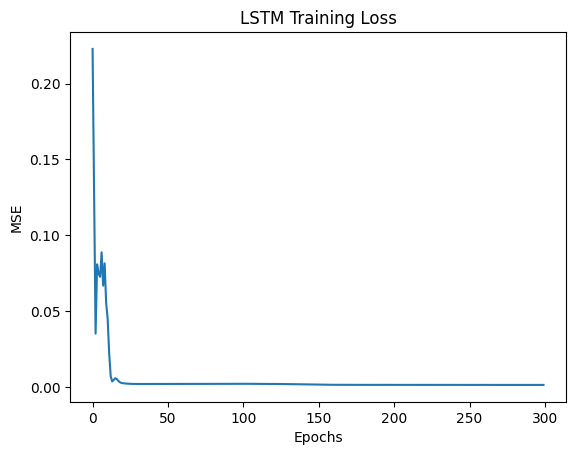

In [442]:
plt.plot(losses)
plt.title('LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [480]:
lstm_model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        output = lstm_model(X_batch[0])
        predictions.append(output.cpu().numpy())


In [481]:
predictions = scaler.inverse_transform(np.concatenate(predictions))
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

In [482]:
predictions = predictions.flatten()
y_test_actual = y_test_actual.flatten()

predictions = np.append(predictions, y_test_actual[-1], axis = None)

In [485]:
df_inverse_scaled = scaler.inverse_transform(df_scaled)
dates = df.index
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dates[:len(train_data)],
    y=np.exp(df_inverse_scaled[:len(train_data)].flatten()),
    mode='lines',
    name='Training Data',
    line=dict(color='#42a7f5')
))

fig.add_trace(go.Scatter(
    x=dates[len(train_data):],
    y=np.exp(y_test_actual.flatten()),
    mode='lines',
    name='Test Data',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=dates[len(train_data):],
    y=np.exp(predictions[1:]),
    mode='lines',
    name='LSTM Prediction',
    line=dict(color='green')
))

fig.update_layout(
    title='LSTM Forecasts',
    xaxis_title='Date',
    yaxis_title='Demand',
    title_x=0.5,
)

fig.show()

In [474]:
lstm_mse = mse(y_test_actual, predictions[1:])
lstm_mae = mae(y_test_actual, predictions[1:])

print(f'''LSTM Model
----------------------------------
MAE = {lstm_mae},
MSE = {lstm_mse}
''')

LSTM Model
----------------------------------
MAE = 0.02583243139088154,
MSE = 0.0008928677416406572



### Results & Comparison

|           Model          | MAE    | MSE    | AIC      |
|:------------------------:|--------|--------|----------|
|SARIMA (1,0,2)(1,1,1)[52] | 0.0425 | 0.0032 | -2320.71 |
| Holt Winters             | 0.1013 | 0.0130 | -4420.09 |
| LSTM                     | 0.0258 | 0.0009 |   N/A    |